1477.0
torch.Size([10, 3]) torch.Size([10])


Sample: 100%|██████████| 3100/3100 [34:15,  1.51it/s, step size=5.57e-03, acc. prob=0.640]


(675, 766)


/tmp/ipykernel_3661232/3934260879.py:70: UserWarning: The following kwargs were not used by contour: 'linewidth'
  surf = ax.contourf(X, Y, Z, levels = 100, cmap=cm.coolwarm,


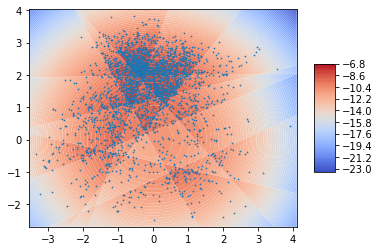

tensor(-0.1726)
tensor([ 1.4601, -0.2010])


In [2]:
import pyro
import pyro.distributions as dist
import torch
import numpy as np
import matplotlib.pyplot as plt

x = np.load("secom_design_matrix.npy")
y = np.load("secom_outcome.npy")

print(np.sum(x[:,0]))

size = 10
x = torch.tensor(x[:size,1:4])
y = torch.tensor(y[:size])

print(x.shape, y.shape)


#def posterior_plot():
from matplotlib import cm
from matplotlib.ticker import LinearLocator




def model(coeff3):
    coeff1 = pyro.sample("c1", dist.Normal(0,1))
    coeff2 = pyro.sample("c2", dist.Normal(0,1))
    coeffs = torch.stack([coeff1,coeff2,coeff3])

    loss = torch.sum((torch.matmul(x.float(), coeffs) * y.float() <= 0))
    score = pyro.sample("loss", dist.Poisson(loss), obs = torch.tensor(0))

    return torch.stack([coeff2,coeff1])
    

from pyro.infer.mcmc import HMC, MCMC, NUTS
from pyro.infer import Importance,EmpiricalMarginal

coeff3 = torch.tensor(1)

nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=3000, warmup_steps=100)
mcmc.run(coeff3)
s = mcmc.get_samples()

c1_min = s["c1"].min().item() - 0.2
c1_max = s["c1"].max().item() + 0.2
c2_min = s["c2"].min().item() - 0.2
c2_max = s["c2"].max().item() + 0.2

fig, ax = plt.subplots()


X = np.arange(c1_min, c1_max, 0.01)
Y = np.arange(c2_min, c2_max, 0.01)
X, Y = np.meshgrid(X, Y)
X = torch.tensor(X)
Y = torch.tensor(Y)

XY = (torch.stack([X, Y, torch.ones_like(X)*coeff3],2)).unsqueeze(3)

pred = torch.matmul(x,XY).squeeze(3)

posterior = dist.Normal(0,1).log_prob(X) + dist.Normal(0,1).log_prob(Y) - torch.sum((pred*y <= 0),2)

Z = posterior.cpu().detach().numpy()

print(Z.shape)
surf = ax.contourf(X, Y, Z, levels = 100, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter('{x:.02f}')

fig.colorbar(surf, shrink=0.5, aspect=5)

ax.scatter(s["c1"],s["c2"], s=0.5)
plt.show()

print((s["c1"]*s["c2"]).mean())

importance = Importance(model, num_samples = 10000).run(coeff3)

marginal_dist = EmpiricalMarginal(importance)
print(marginal_dist.mean)